# Install Dependencies

## External Dependencies

In [11]:
!pip install pandas

## FrostAura Dependencies

In [12]:
import os
import sys

USE_LOCAL_CODE: bool = True # NOTE: When changing this configuration, be sure to restart the interpreter in order to have sys path updates reflect.
directories_to_move_up: int = 2
current_executing_path: str = os.getcwd()
current_executing_path = current_executing_path.replace('\\', '/')
root_path: str = '/'.join(current_executing_path.split('/')[:-directories_to_move_up])

# Clean up.
%pip uninstall frostaura -y
sys.path = [p for p in sys.path if p != root_path]

if USE_LOCAL_CODE:
    sys.path.append(root_path)
else:
    %pip install -U --no-cache-dir frostaura

Note: you may need to restart the kernel to use updated packages.


## Logging

In [13]:
import logging

logging.basicConfig(level=logging.DEBUG)

# Import Dependencies

In [14]:
%run ./asset_valuation_engine.finviz.ipynb

INFO:root:Fetching HTML page from URL "https://finviz.com/quote.ashx?t=AAPL".
DEBUG:root:User agent override found in config. Using value "PostmanRuntime/7.29.0".
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): finviz.com:443


Note: you may need to restart the kernel to use updated packages.


DEBUG:urllib3.connectionpool:https://finviz.com:443 "GET /quote.ashx?t=AAPL HTTP/1.1" 200 None
DEBUG:root:EPS: 6.05, EPS Next 5 Years: 0.0983%
DEBUG:root:P/E Ratio: 27.585, Current Price: $ 172.1
DEBUG:root:Intrinsic Value: $ 128.37634615384616 vs. Current Price: $ 172.1


DEBUG:root:Calculating profit for asset "TSLA".
INFO:root:Fetching historical price movements for symbol "TSLA".
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): query2.finance.yahoo.com:443


Note: you may need to restart the kernel to use updated packages.


DEBUG:urllib3.connectionpool:https://query2.finance.yahoo.com:443 "GET /v8/finance/chart/TSLA?period1=-631159200&period2=1660428699&interval=1d&includePrePost=False&events=div%2Csplits HTTP/1.1" 200 None
DEBUG:root:[TSLA] Processing transaction value $0.0688 on 2022-07-28 00:00:00.
DEBUG:root:Calculating profit for asset "AAPL".
INFO:root:Fetching historical price movements for symbol "AAPL".
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): query2.finance.yahoo.com:443
DEBUG:urllib3.connectionpool:https://query2.finance.yahoo.com:443 "GET /v8/finance/chart/AAPL?period1=-631159200&period2=1660428700&interval=1d&includePrePost=False&events=div%2Csplits HTTP/1.1" 200 None
DEBUG:root:[AAPL] Processing transaction value $0.4317 on 2022-07-01 00:00:00.
DEBUG:root:Calculating profit for asset "DDD".
INFO:root:Fetching historical price movements for symbol "DDD".
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): query2.finance.yahoo.com:443
DEBUG:urllib3.connection

{'percentage': 6.4668673292609835, 'value': 16.69773357162481}


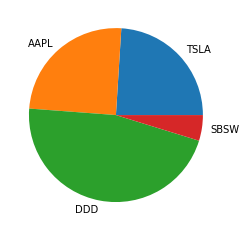

In [15]:
%run ./asset_calculations_engine.simple.ipynb

In [16]:
from frostaura.engines import IAssetProjectionEngine
from frostaura.engines import SimpleAssetProjectionEngine
import pandas as pd
from frostaura.engines import IAssetValuationEngine
from frostaura.engines import FinvizAssetValuationEngine
from frostaura.data_access import IResourcesDataAccess
from frostaura.data_access import HtmlResourcesDataAccess
from frostaura.models import ValuationResult

# Usage

In [17]:
instance: IAssetProjectionEngine = SimpleAssetProjectionEngine()
html_data_access: IResourcesDataAccess = HtmlResourcesDataAccess()
asset_valuation_engine: IAssetValuationEngine = FinvizAssetValuationEngine(html_data_access=html_data_access)

In [18]:
n_months: int = 12*30 # 39 year
usd_zar_exchange_rate: float = 16.17
annual_growth_rate: float = valuation.eps_five_years + (valuation.annual_dividend_percentage / 100)
initial_value: float = holdings['AAPL']['total_current_usd']
growth: pd.DataFrame = instance.project_monthly_asset_growth(n_months=n_months,
                                                             annual_growth_rate=annual_growth_rate,
                                                             principal_value=initial_value,
                                                             monthly_deposit=(1000 / usd_zar_exchange_rate / 4))

growth

,deposits_withdrawals,interest,total_deposits_withdrawals,accrued_interest,balance
month,,,,,
0,0.00000,0.000000,0.000000,0.000000,74.295573
1,15.46073,0.641418,15.460730,0.641418,90.397721
2,15.46073,0.780434,30.921459,1.421852,106.638884
3,15.46073,0.920649,46.382189,2.342501,123.020263
4,15.46073,1.062075,61.842919,3.404576,139.543068
...,...,...,...,...,...
356,15.46073,325.113061,5504.019790,32420.141983,37998.457345
357,15.46073,328.053348,5519.480519,32748.195331,38341.971423
358,15.46073,331.019020,5534.941249,33079.214351,38688.451173


In [19]:
annual_growth_rates: list = list()
principal_values: list = list()
monthly_deposits: list = list()

for symbol in holdings:
    company_name: str = holdings[symbol]['name']
    symbol_valuation: ValuationResult = asset_valuation_engine.valuate(company_name=company_name, symbol=symbol)
    annual_growth_rate: float = symbol_valuation.eps_five_years

    if symbol_valuation.annual_dividend_percentage is not None:
        annual_growth_rate += (symbol_valuation.annual_dividend_percentage / 100)

    annual_growth_rates.append(annual_growth_rate)
    principal_values.append(holdings[symbol]['total_current_usd'])
    monthly_deposits.append((1000 / usd_zar_exchange_rate / len(holdings)))

holdings_growth: pd.DataFrame = instance.project_monthly_holdings_growth(n_months=n_months,
                                                                         annual_growth_rates=annual_growth_rates,
                                                                         principal_values=principal_values,
                                                                         monthly_deposits=monthly_deposits)

holdings_growth

INFO:root:Fetching HTML page from URL "https://finviz.com/quote.ashx?t=TSLA".
DEBUG:root:User agent override found in config. Using value "PostmanRuntime/7.29.0".
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): finviz.com:443
DEBUG:urllib3.connectionpool:https://finviz.com:443 "GET /quote.ashx?t=TSLA HTTP/1.1" 200 None
DEBUG:root:EPS: 8.33, EPS Next 5 Years: 0.5189%
DEBUG:root:P/E Ratio: 80.48, Current Price: $ 900.09
DEBUG:root:Intrinsic Value: $ 515.6910769230769 vs. Current Price: $ 900.09
INFO:root:Fetching HTML page from URL "https://finviz.com/quote.ashx?t=AAPL".
DEBUG:root:User agent override found in config. Using value "PostmanRuntime/7.29.0".
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): finviz.com:443
DEBUG:urllib3.connectionpool:https://finviz.com:443 "GET /quote.ashx?t=AAPL HTTP/1.1" 200 None
DEBUG:root:EPS: 6.05, EPS Next 5 Years: 0.0983%
DEBUG:root:P/E Ratio: 27.585, Current Price: $ 172.1
DEBUG:root:Intrinsic Value: $ 128.37634615384616

,month,deposits_withdrawals,interest,total_deposits_withdrawals,accrued_interest,balance
0,1,61.842919,0.023585,61.842919,6.236877e+00,3.262842e+02
1,2,61.842919,0.023436,123.685838,1.406721e+01,3.959574e+02
2,3,61.842919,0.023366,185.528757,2.354046e+01,4.672736e+02
3,4,61.842919,0.023341,247.371676,3.470787e+01,5.402839e+02
4,5,61.842919,0.023346,309.214595,4.762258e+01,6.150415e+02
...,...,...,...,...,...,...
355,356,61.842919,0.041390,22016.079159,1.476355e+09,1.476377e+09
356,357,61.842919,0.041391,22077.922078,1.540103e+09,1.540125e+09
357,358,61.842919,0.041393,22139.764997,1.606605e+09,1.606628e+09
358,359,61.842919,0.041394,22201.607916,1.675981e+09,1.676004e+09


In [20]:
over_1b = holdings_growth.loc[holdings_growth['balance'] > 1000000000]

print(f'{round(over_1b.index[0] / 12, 2)} years to ${over_1b.iloc[0]["balance"]:.2f}.')

28.83 years to $1009233520.64.


In [36]:
data = {
    'Target Balance (USD)': list(),
    'ETA (Months)': list(),
    'ETA (Years)': list()
}

# $ 100 000
hundred_thousand: int = holdings_growth.loc[holdings_growth['balance'] > 100*1000]

data['Target Balance (USD)'].append(f'{hundred_thousand.iloc[0]["balance"]:.2f}')
data['ETA (Months)'].append(hundred_thousand.index[0])
data['ETA (Years)'].append(hundred_thousand.index[0] / 12)

# 100 000 0
million: int = holdings_growth.loc[holdings_growth['balance'] > 100*1000*10]

data['Target Balance (USD)'].append(f'{million.iloc[0]["balance"]:.2f}')
data['ETA (Months)'].append(million.index[0])
data['ETA (Years)'].append(million.index[0] / 12)

# 100 000 00
ten_million: int = holdings_growth.loc[holdings_growth['balance'] > 100*1000*10*10]

data['Target Balance (USD)'].append(f'{ten_million.iloc[0]["balance"]:.2f}')
data['ETA (Months)'].append(ten_million.index[0])
data['ETA (Years)'].append(ten_million.index[0] / 12)

# 100 000 00
hundred_million: int = holdings_growth.loc[holdings_growth['balance'] > 100*1000*10*100]

data['Target Balance (USD)'].append(f'{hundred_million.iloc[0]["balance"]:.2f}')
data['ETA (Months)'].append(hundred_million.index[0])
data['ETA (Years)'].append(hundred_million.index[0] / 12)

# 100 000 000
billion: int = holdings_growth.loc[holdings_growth['balance'] > 100*1000*10*1000]

data['Target Balance (USD)'].append(f'{billion.iloc[0]["balance"]:.2f}')
data['ETA (Months)'].append(billion.index[0])
data['ETA (Years)'].append(billion.index[0] / 12)

pd.DataFrame(data)

,Target Balance (USD),ETA (Months),ETA (Years)
0,103148.27,123,10.250000
1,1014443.47,181,15.083333
2,10260911.67,237,19.750000
3,103299382.59,292,24.333333
4,1009233520.64,346,28.833333
